# [HW 2: Projection Matrix and Fundamental Matrix Estimation with RANSAC]()

1. Projection Matrix  
2. Fundamental Matrix Estimation  
3. Fundamental Matrix with RANSAC  

## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
import cv2
import numpy as np
import matplotlib.pyplot as plt
from proj2_code.utils import *

# Part 1 Projection Matrix Estimation

## Part 1.1 Implement Camera Projection

In this initial part, in `projection_matrix.py` you will implement camera projection in the `projection(P, points_3d)` from homogenous world coordinates $X_i = [X_i, Y_i, Z_i, 1]$ to non-homogenous pixel coordinates $x_i, y_i$.

It will be helpful to recall the equations to convert to pixel coordinates

\begin{align}
x_i = \frac{p_{11}X_i+p_{12}Y_i + p_{13}Z_i + p_{14}}{p_{31}X_i+p_{32}Y_i + p_{33}Z_i + p_{34}} \quad y_i = \frac{p_{21}X_i+p_{22}Y_i + p_{23}Z_i + p_{24}}{p_{31}X_i+p_{32}Y_i + p_{33}Z_i + p_{34}}
\end{align}

In [2]:
import projection_matrix
np.set_printoptions(suppress=True) # Suppresses printing in scientific notation

from proj2_unit_tests.part1_unit_test import (
    verify, 
    test_projection, 
    test_objective_func,
    test_decompose_camera_matrix,
    test_calculate_camera_center,
    test_estimate_camera_matrix)

In [3]:
print('Test for camera projection:', verify(test_projection))

Test for camera projection: "Correct"


## Part 1.2: Objective Function 

In this part, in `projection_matrix.py` you will implement the objective function `objective_function(x, **kwargs)` that will be passed to `scipy.optimize.least_squares` for minimization with the Levenberg-Marquardt algorithm. The input to this function is a [vectorized](https://en.wikipedia.org/wiki/Vectorization_(mathematics)) camera matrix, the output is the term that gets squared in the objective function and should also be vectorized. Scipy takes care of the squaring + summation part.

\begin{align}
\sum_{i=1}^N ( \color{purple}{\hat{\mathbf{P}}\mathbf{X}_w^i-\mathbf{x}^i })^2
\end{align}

In [4]:
print('Test for objective_function:', verify(test_objective_func))

Test for objective_function: "Correct"


## Part 1.3: Estimating the Projection Matrix Given Point Correspondences

Initially you will run the optimization to estimate $\mathbf{P}$ using an initial guess that we provide.

### Good initial estimate for $\mathbf{P}$.

Optimizing the reprojection loss using Levenberg-Marquardt requires a good initial estimate for $\mathbf{P}$. This can be done by having good initial estimates for $\mathbf{K}$ and $\mathbf{R}^T$ and $\mathbf{t}$ which you can multiply to then generate your estimated $\mathbf{K}$.

In [5]:
initial_guess_K = np.array([[ 500,   0, 535],
                            [   0, 500, 390],
                            [   0,   0,  -1]])

initial_guess_R_T = np.array([[ 0.5,   -1,  0],
                            [   0,    0, -1],
                            [   1,  0.5,  0]])

initial_guess_I_t = np.array([[   1,    0, 0, 300],
                              [   0,    1, 0, 300],
                              [   0,    0, 1,  30]])

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

In [6]:
# set the paths and load the data
pts2d_path = '../data/pts2d-pic_b.txt'
pts3d_path = '../data/pts3d.txt'
img_path   = '../data/pic_b.jpg'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(img_path)

### Estimate the projection matrix given corresponding 2D & 3D points

[   785.    -232.5      0.  165750.     390.     195.    -500.  160500.
     -1.      -0.5      0.    -450. ]
`ftol` termination condition is satisfied.
Function evaluations 1019, initial cost 2.9929e+07, final cost 6.8831e+00, first-order optimality 2.76e+05.
Time since optimization start 0.029918909072875977
The projection matrix is
 [[ -2.04554471   1.18126294   0.4055897  244.82283619]
 [ -0.45582852  -0.30414815   2.14988436 166.18819426]
 [ -0.00224223  -0.00109957   0.00057155   1.        ]]
The total residual is 14.711445


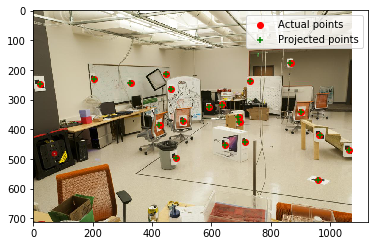

In [7]:
P = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)

print('The projection matrix is\n', P)

[projected_2d_pts, residual] = evaluate_points(P, points_2d, points_3d);

# residual is the sum of Euclidean distances between actual and projected points
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, '../data/pic_b.jpg')


In [8]:
print('Test for estimate_camera_matrix:', verify(test_estimate_camera_matrix))

[   785.    -232.5      0.  165750.     390.     195.    -500.  160500.
     -1.      -0.5      0.    -450. ]
`ftol` termination condition is satisfied.
Function evaluations 1019, initial cost 2.9929e+07, final cost 6.8831e+00, first-order optimality 2.76e+05.
Time since optimization start 0.031914472579956055
Test for estimate_camera_matrix: "Correct"


## Part 1.4: Decomposing the projection matrix

In this part in `projection_matrix.py` you will implement `decompose_camera_matrix(P)` that takes as input the camera matrix $\mathbf{P}$ and outputs the intrinsic $\mathbf{K}$ and rotation matrix ${}_c\mathbf{R}_w$, 

In [9]:
print('Test for decomposing projection matrix:', verify(test_decompose_camera_matrix))
K, R = projection_matrix.decompose_camera_matrix(P)

Test for decomposing projection matrix: "Correct"


## Part 1.5: Calculating Camera Center

In this part in `projection_matrix.py` you will implement `calculate_camera_center(P, K, R)` that takes as input the 
projection $\mathbf{P}$, intrinsic $\mathbf{K}$ and extrinsic ${}_c\mathbf{R}_w$ matrix and outputs the camera position in world coordinates.

In [10]:
print('Test for calculating camera center:', verify(test_calculate_camera_center))
center = projection_matrix.calculate_camera_center(P, K, R)

Test for calculating camera center: "Correct"


We can now visualize the camera center and the camera coordinate system as well as the  the world coordinate system.

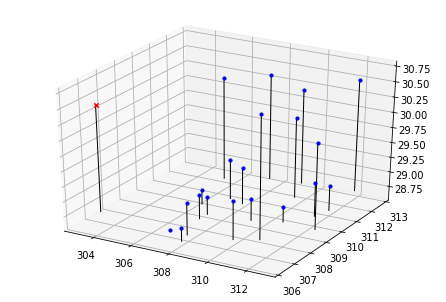

In [11]:
plot3dview(points_3d, center)

## Part 1.6: Taking Your Own Images and Estimating the Projection Matrix + Camera Pose

In this part you will take two images of your fiducial object. If you want to also reuse these images for Part II, keep in mind how to take good images for estimating the Fundamental Matrix.

In [12]:
image1_path = '../data/boximg1.jpg' #'../data/book_img1.jpg'
image2_path = '../data/boximg2.jpg' #'../data/book_img2.jpg'

img1 = load_image(image1_path)
img2 = load_image(image2_path)

Measure your fiducial object and define a coordinate system. Fill out the `points_3d` variable with the 3D point locations of the points you'll use for correspondences.

In [13]:
points_3d = np.array([[0    , 0,  0],
                      [30 , 0,  0],
                      [0    , 20, 0],
                      [0    , 0,  15],
                      [30 , 0 , 15],
                      [30 , 20, 15],
                      [0    , 20, 15]])

Now for each image, find the 2D pixel locations of your 3D points. Hovering over the image gives you the `x,y` coordinates of your cursor on the image. You can use the lower left side controls to zoom into the image for more precise measurements. Fill out `points2d_img1` with these coordinate values.

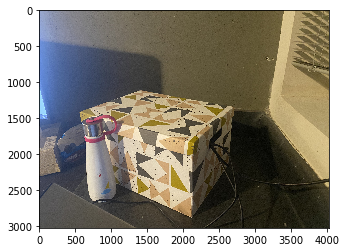

In [14]:
# plotting image 1
fig = plt.figure(); ax = fig.add_subplot(111); ax.imshow(img1)

In [15]:
points2d_img1 = np.array([[2110,  2880],
                          [700,  2320],
                          [2625, 2160],
                          [2145,  1850],
                          [560,  1400],
                          [1400, 1100],
                          [2700, 1335]])

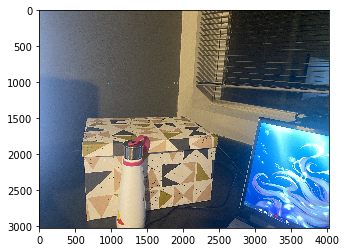

In [16]:
# plotting image 2
fig = plt.figure(); ax = fig.add_subplot(111); ax.imshow(img2)

In [17]:
points2d_img2 = np.array([[2390, 2625],
                          [650, 2910],
                          [1980,2150],
                          [2485, 1760],
                          [590, 1880],
                          [670, 1495 ],
                          [2000, 1470]])

Our objective function will need to read the measurements you just saved from disk. We need to save this data now.

In [18]:
np.savetxt('../data/pts3d_fiducial.npy', points_3d)
np.savetxt('../data/pts2d_image1.npy', points2d_img1)
np.savetxt('../data/pts2d_image2.npy', points2d_img2)

## Part 1.7: Making your own $\mathbf{K}$,  $\mathbf{R}^T$ and $[\mathbf{I}|\mathbf{t}]$ estimates.

In [19]:
initial_guess_K = np.array([[ 500,   0, 2024],
                            [   0, 500, 1518],
                            [   0,   0,  1]])

initial_guess_R_T = np.array([[ 0.5,   -1,  0],
                            [   0,    0, -1],
                            [   1,  0.5,  0]])

initial_guess_I_t = np.array([[   1,    0, 0, -30],
                              [   0,    1, 0, -30],
                              [   0,    0, 1, 30]])

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

In [20]:
# set the paths and load the data
pts2d_path = '../data/pts2d_image1.npy'
pts3d_path = '../data/pts3d_fiducial.npy'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(image1_path)
np.array(img.shape[:2])/2

array([1512., 2016.])

Visualize your estimate for the camera pose relative to the world coordinate system. RGB colors correspond with XYZ (first, second and third coordinate). Be mindful of whether you should be passing `R` or `R.T` in for your rotation matrix.

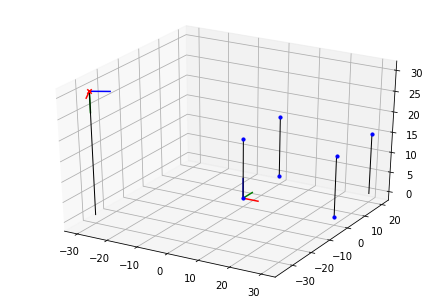

In [21]:
plot3dview_with_coordinates(points_3d, initial_guess_I_t[:,3], initial_guess_R_T.T)

View the optimization results given your initial guess. If your initial guess is poor the optimizition **will not** work. You will need to make initial estimates for both the images you took.

[  2274.     512.       0.  -83580.    1518.     759.    -500.  -83310.
      1.       0.5      0.     -45. ]
`ftol` termination condition is satisfied.
Function evaluations 238, initial cost 1.5523e+10, final cost 2.4689e+02, first-order optimality 1.50e-01.
Time since optimization start 0.009998321533203125
The projection matrix is
 [[ -42.00905925   70.155281    -16.45511475 2113.01387072]
 [  -2.11119585    1.01353697  -85.35868721 2882.56283803]
 [   0.00729292    0.01706755   -0.00867521    1.        ]]
The total residual is 53.911936


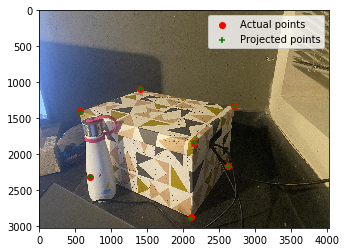

In [22]:
P1 = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)
print('The projection matrix is\n', P1)

[projected_2d_pts, residual] = evaluate_points(P1, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, image1_path)

Visualize your estimate for the camera pose relative to the world coordinate system.

In [23]:
# set the pats and load the data
pts2d_path = '../data/pts2d_image2.npy'
pts3d_path = '../data/pts3d_fiducial.npy'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(image1_path)
np.array(img.shape[:2])/2

array([1512., 2016.])

In [24]:
initial_guess_K = np.array([[ 500,   0, 2024],
                            [   0, 500, 1518],
                            [   0,   0,  1]])

initial_guess_R_T = np.array([[ 0.5,   -1,  0],
                            [   0,    0, -1],
                            [   1,  0.5,  -0.5]])

initial_guess_I_t = np.array([[   1,    0, 0, -30],
                              [   0,    1, 0, -10],
                              [   0,    0, 1, 30]])

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

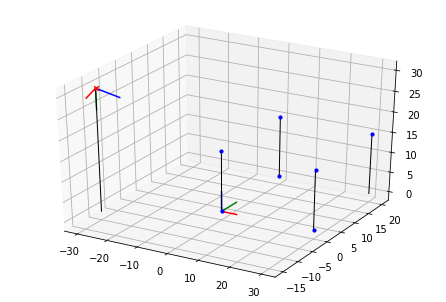

In [25]:
plot3dview_with_coordinates(points_3d, initial_guess_I_t[:,3], initial_guess_R_T.T) #change this plot to show the world coordinate system better

[   2274.      512.    -1012.  -103700.     1518.      759.    -1259.
  -90900.        1.        0.5      -0.5     -50. ]
`ftol` termination condition is satisfied.
Function evaluations 252, initial cost 1.1320e+10, final cost 4.6119e+02, first-order optimality 8.34e-01.
Time since optimization start 0.011966228485107422
The projection matrix is
 [[ -61.5335489    14.70873399   -6.54462023 2389.5761121 ]
 [  -7.16474323   13.32883331  -67.20178753 2634.23351675]
 [  -0.00564738    0.01800177   -0.00507114    1.        ]]
The total residual is 73.965891


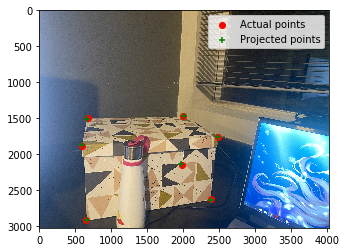

In [26]:
P2 = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)
#M = sc.calculate_projection_matrix(points_2d, points_3d)
print('The projection matrix is\n', P2)

[projected_2d_pts, residual] = evaluate_points(P2, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, image2_path)
#visualize_points(points_2d, projected_2d_pts)

## Part 1.8 Visualizing both camera poses in the world coordinate system

[-18.72082694 -33.39270043  33.83652594]
[ 26.42018156 -39.20324261  28.60647439]


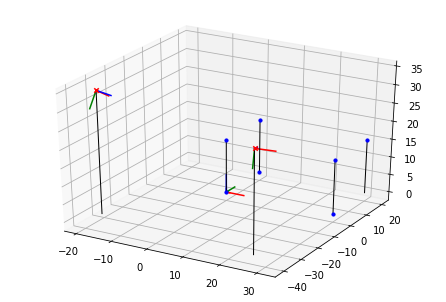

In [27]:
K1, R1 = projection_matrix.decompose_camera_matrix(P1)
center_1 = projection_matrix.calculate_camera_center(P1, K1, R1);
print(center_1)

K2, R2 = projection_matrix.decompose_camera_matrix(P2)
center_2 = projection_matrix.calculate_camera_center(P2, K2, R2);
print(center_2)

plot3dview_2_cameras(points_3d, center_1, center_2, R1.T, R2.T)

# Part 2 Fundamental Matrix Estimation

In this part you'll be estimating the fundamental matrix. You'll be using a least squares optimizer from SciPy. (Documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)

The least squares optimizer takes an objective function, your variables to optimize, and the points that you want to fit a line to. In this case, the objective function is to minimize the point to line distance, where the line is the projection of a point onto another image by the fundamental matrix, and the point is an actual point of a feature in that image. The variable that you want to optimize would be the 9 values in the 3x3 Fundamental Matrix. The points that you are optimizing over are provided to you, and they are the homogeneous coordinates of corresponding features from two different images of the same scene.

## Part 2.1 Estimate Fundamental Matrix

Implement the `point_line_distance()` method in fundamental_matrix.py.

\begin{align}
    d(line, point) = \frac{au + bv + c}{\sqrt{a^2 + b^2}}
\end{align}

In [28]:
from proj2_unit_tests.test_fundamental_matrix import verify
from proj2_unit_tests.test_fundamental_matrix import TestFundamentalMatrix

test_fundamental_matrix_stereo = TestFundamentalMatrix()
TestFundamentalMatrix.setUp(test_fundamental_matrix_stereo)
print("test_point_line_distance(): " + verify(test_fundamental_matrix_stereo.test_point_line_distance))
print("test_point_line_distance_zero(): " + verify(test_fundamental_matrix_stereo.test_point_line_distance_zero))

test_point_line_distance(): "Correct"
test_point_line_distance_zero(): "Correct"


Implement `signed_point_line_errors()`.

Keep in mind that SciPy does the squaring and summing for you, so all you have to do in `signed_point_line_errors()` is return a list of each individual error. So if there are 9 points, you have to calculate the `point_line_distance()` between each pair from $Fx_1$ to $x_0$ and also $F^Tx_0$ to $x_1$, then append all errors to a list, such that you end up returning a list of length 18. SciPy will take the list and square each element and sum everything for you. The red parts in the equation below are the parts you'll need to implement.

`signed_point_line_errors()`:
\begin{align}
    \color{red}{d(Fx_1, x_0)}^2 + \color{red}{d(F^T x_0, x_1)}^2
\end{align}

You'll also have to make the call to SciPy's least squares optimizer in the `optimize()` method in least_squares_fundamental_matrix.py.

In [29]:
from proj2_unit_tests.test_fundamental_matrix import TestFundamentalMatrix2, TestFundamentalMatrix3

print("TestFundamentalMatrix():")
print("test_signed_point_line_errors(): " + verify(test_fundamental_matrix_stereo.test_signed_point_line_errors))
print("test_least_squares_optimize(): " + verify(test_fundamental_matrix_stereo.test_least_squares_optimize))

print("TestFundamentalMatrix2():")
test_fundamental_matrix_synthetic = TestFundamentalMatrix2()
TestFundamentalMatrix2.setUp(test_fundamental_matrix_synthetic)
print("test_signed_point_line_errors(): " + verify(test_fundamental_matrix_synthetic.test_signed_point_line_errors))
print("test_least_squares_optimize(): " + verify(test_fundamental_matrix_synthetic.test_least_squares_optimize))

print("TestFundamentalMatrix3():")
test_fundamental_matrix_real = TestFundamentalMatrix3()
TestFundamentalMatrix3.setUp(test_fundamental_matrix_real)
print("test_signed_point_line_errors(): " + verify(test_fundamental_matrix_real.test_signed_point_line_errors))
print("test_least_squares_optimize(): " + verify(test_fundamental_matrix_real.test_least_squares_optimize))

TestFundamentalMatrix():
test_signed_point_line_errors(): "Correct"
test_least_squares_optimize(): "Correct"
TestFundamentalMatrix2():
test_signed_point_line_errors(): "Correct"
test_least_squares_optimize(): "Correct"
TestFundamentalMatrix3():
test_signed_point_line_errors(): "Correct"
test_least_squares_optimize(): "Correct"


Then run the following cell to find the Fundamental Matrix using least squares. You should see the epipolar lines in the correct places in the image. **You'll need to screenshot this and put it in your report.**

[[-0.00005608  0.00059327 -0.014601  ]
 [ 0.00087223 -0.00015445 -2.39641427]
 [-0.22260075  1.74869963 57.12943309]]


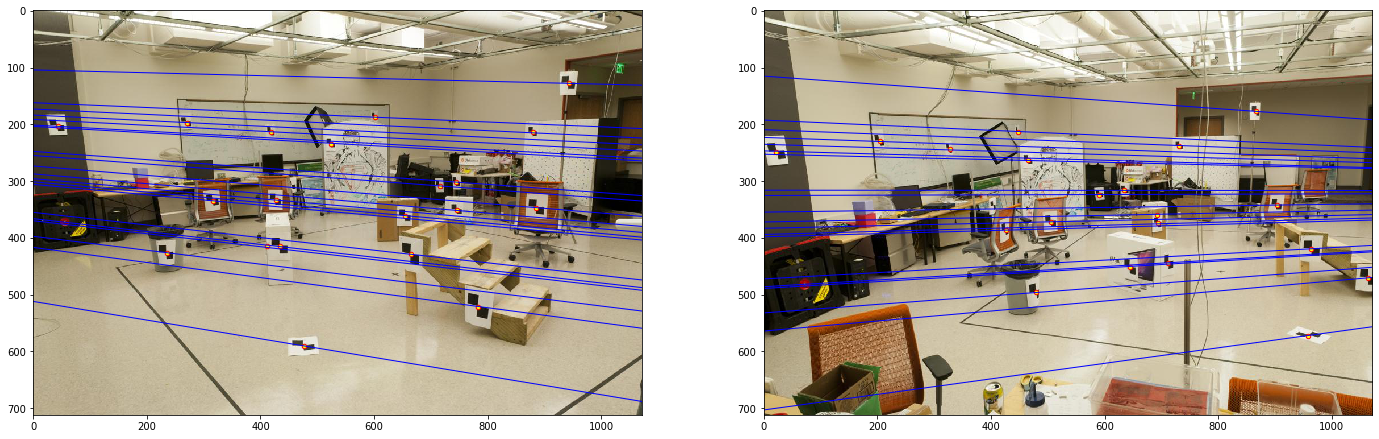

In [30]:
%matplotlib inline
# Load the data for room images
points_2d_pic_a = np.loadtxt('../data/pts2d-pic_a.txt')
points_2d_pic_b = np.loadtxt('../data/pts2d-pic_b.txt')
img_left = load_image('../data/pic_a.jpg')
img_right = load_image('../data/pic_b.jpg')

import least_squares_fundamental_matrix as ls

F = ls.solve_F(points_2d_pic_a, points_2d_pic_b)
print(F)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(F, img_left, img_right, points_2d_pic_a, points_2d_pic_b)

## Part 2.2 Try Fundamental Matrix Estimation Yourself

Now you're going to take two images yourself and estimate the fundamental matrix between them. To do this, take two images and save them as "my_image_0.jpg" and "my_image_1.jpg" in the "/data" folder.

In [31]:
# Load the data for room images
my_img_left = load_image('../data/boximg1.jpg')#load_image('../data/my_image_0.jpg')
my_img_right = load_image('../data/boximg2.jpg')#load_image('../data/my_image_1.jpg')

To collect your own data points, run the following cell and mouse over features in the image and record the x- and y-coordinates. You'll need at least 9 points because we are trying to optimize for 9 variables, one for each element in the 3x3 fundamental matrix. Think about how you can choose good features for estimating the fundamental matrix.

Store your points in variable "my_image_0_pts" and "my_image_1_pts" respectively.

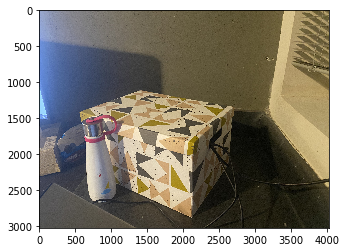

In [32]:
# plotting image 1
image_0 = plt.figure(); image_0_ax = image_0.add_subplot(111); image_0_ax.imshow(my_img_left)

In [33]:
my_image_0_pts = np.array([[2110,  2880],
                          [700,  2320],
                          [2625, 2160],
                          [2145,  1850],
                          [560,  1400],
                          [1400, 1100],
                          [2700, 1335],
                          [720, 1505],
                          [3350, 1200]])

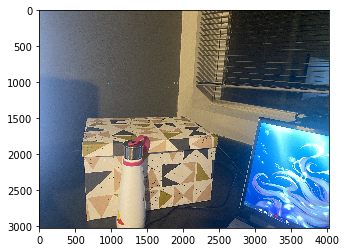

In [34]:
# plotting image 2
image_1 = plt.figure(); image_1_ax = image_1.add_subplot(111); image_1_ax.imshow(my_img_right)

In [35]:
my_image_1_pts = np.array([[2390, 2625],
                          [650, 2910],
                          [1980,2150],
                          [2485, 1760],
                          [590, 1880],
                          [670, 1495 ],
                          [2000, 1470],
                          [1300, 1815],
                          [2125, 1340]])

[[  -0.00000768   -0.00000432    0.02764385]
 [   0.00004031   -0.00001964   -0.18972044]
 [  -0.01123985    0.22323871 -137.40056102]]


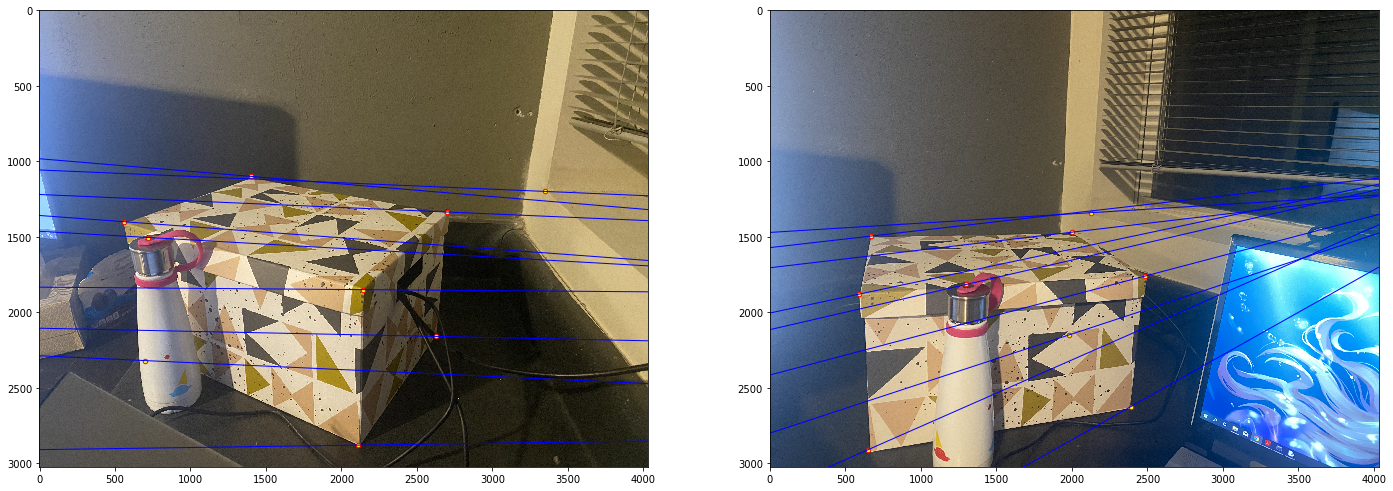

In [36]:
%matplotlib inline
import two_view_data as two_view_data
my_F = ls.solve_F(my_image_0_pts, my_image_1_pts)
print(my_F)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(my_F, my_img_left, my_img_right, my_image_0_pts, my_image_1_pts)

### Part 3: Fundamental Matrix with RANSAC (Szeliski 6.1.4)

Now we will automate the process of finding the fundamental matrix for an image pair by using proposed interest points and using RANSAC to robustly find true interest point matches between the two images. We will give you some proposed interest points with an accuracy of approximately 90%. You will learn how to find these proposed interest points later in the class.

After we have proposed interest points, then RANSAC will select a random subset of those points, 
you will call your function from part 2 to calculate the fundamental matrix for those points, 
and then you will check how many other proposed interest points match this
fundamental matrix. Then you will repeat this process and select another subset of points using RANSAC until you find the subset of points that produces the best fundamental matrix with the most
matching points. Refer to the lecture slides for the RANSAC workflow. Keep in mind that although the fundamental matrix does not normally have 9 degrees of freedom, the way we are performing the optimization in part 2 does not enforce any constraints on the matrix, and so we need 9 point correspondences to perform the optimization for the 9 variables.

You can also find a simple explanation of RANSAC at 
https://www.mathworks.com/discovery/ransac.html.
See section 6.1.4 in the textbook for a more thorough explanation of how RANSAC works.

### Part 3.1: RANSAC Iterations
Begin by calculating the number of iterations $S$ RANSAC will need to perform to guarentee a given success rate $P$ knowing the number of points included in the sample $k$ and the probability of an individual point being a true match $p$. To derive this formula, consider the following:
 * the probability that any one point has a true match is $p$
  * conversely the probability that any one point is not a match is $1-p$
  * the probability that two points are both matches is then $p \cdot p$
  * this can be extendeed to $k$ points, for which the probability that they are all true matches is $p^k$
 * on the other hand, we want the probability that $k$ points are all true matches to be $P$ (and the probability that they are not to be $1-P$)
 * by repeatedly sampling $k$ points, we can reduce the probability that all of the samples do not contain $k$ true matches
 * After $S$ samples we want the probability of failure to equal $1-P$
 
Start by setting up this equality $$1-P = ...$$
and then rearange it to write a function to solve for $S$

In [37]:
from ransac import calculate_num_ransac_iterations
from proj2_unit_tests.test_ransac import test_calculate_num_ransac_iterations

P = 0.999
k = 9
p = 0.90
# call their ransac iterations function
S = calculate_num_ransac_iterations(P, k, p)
# print number of trials they will need to run
print('S =', int(S))

print("Test for calculate_num_ransac_iterations(): " + verify(test_calculate_num_ransac_iterations))

S = 15
Test for calculate_num_ransac_iterations(): "Correct"


### Questions
*put these answers in your report*

What is the **minimum** number of RANSAC iterations we would we need to find the fundamental matrix with 99.9% certainty from a set of proposed matches that have a 90% point correspondence accuracy? *Keep in mind that we need at least 9 point correspondences for our optimization to find the fundamental matrix in part 2*

One might imagine that if we had more than 9 point correspondences, it would be better to use more of them to solve for the fundamental matrix. Investigate this by finding the number of RANSAC iterations you would need to run for the above situation with 18 points.

If our dataset had a lower point correspondence accuracy, say 70%, what is the minimum number of iterations needed to find the fundamental matrix with 99.9% certainty?

At the end of this assignment you will be performing RANSAC to find the fundamental matrix for an image pair, and you will want to keep these results in mind when deciding how many iterations to perform. For example, we have shown that you want to use the minimum number of points in order to make it easier to find a sample with no outliers. You will also want to keep the accuracy and probability of success in mind.

### Part 3.2: RANSAC Implementation
Next we will implement the RANSAC algorithm. Remember the steps from the link above:
 1. Randomly selecting a subset (k=9) of the data set
 1. Fitting a model to the selected subset
 1. Determining the number of outliers
 1. Repeating steps 1-3 for a prescribed number of iterations

For the application of finding true point pair matches and using them to calculate the fundamental matrix, our subset of the data will be the minimum number of point pairs needed to calculate the fundamental matrix.
The model we are fitting is the fundamental matrix.
Outliers will be found by using the `point_line_distance()` error function from part 2 and thresholding with a certain margin of error.

In [38]:
from ransac import ransac_fundamental_matrix
from proj2_unit_tests import test_ransac

points_a = np.load('../data/pointsa.npy')
points_b = points_a

F, _, _ = ransac_fundamental_matrix(points_a, points_b)
print('F= ', F)

print("Test for ransac_find_inliers(): " + verify(test_ransac.test_ransac_find_inliers))
print("Test for ransac_fundamental_matrix(), F matches inliers: " + verify(test_ransac.test_ransac_fundamental_matrix_error))
print("Test for ransac_fundamental_matrix(), F matches all points: " + verify(test_ransac.test_ransac_fundamental_matrix_fit))

F=  [[ 0.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
[ 0  2  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29]
Test for ransac_find_inliers(): "Correct"
average residual =  0.06647121423298692
Test for ransac_fundamental_matrix(), F matches inliers: "Correct"
average residual =  7.542500292739918
Test for ransac_fundamental_matrix(), F matches all points: "Correct"


### Part 3.3: Finally we will put it all together

The code below will load precomputed feature point correspondence proposals from two images and run your RANSAC calculating the fundamental matrix with your function at each pass. You shouldn't have to implement any new functions for this.

This code will display the proposed point correspondences. Note that there are a number of spurious matches. After running your RANSAC it will display the inlier point correspondences and epipolar lines for each feature point according to the fundamental matrix that your code found. You can use these images as a final check. It is possible that some false correspondences will slip through, but most of them should be eliminated, and there should be a clear epipole at the camera center shown in the image. Review the lecture materials if you don't remember the significance of epipolar lines and epipoles.

In [39]:
# from feature_matching.extraction import get_matches
from feature_matching.utils import PIL_resize
import matplotlib.pyplot as plt

# Notre Dame
image1 = load_image('../data/IMG_4407.jpeg')
image2 = load_image('../data/IMG_0788.jpeg')


from feature_matching.utils import show_interest_points
from feature_matching.utils import show_correspondence_circles, show_correspondence_lines

# from feature_matching.extraction import get_matches
# pts1, pts2 = get_matches(image1, image2)

# load the points from the disk.
# the points are already matched. The first row of pts1 matches with first row of pts2.
pts1 = np.loadtxt('../data/pts_a.txt')
pts2 = np.loadtxt('../data/pts_b.txt')

print('Number of matches loaded = ', pts1.shape[0])

Number of matches loaded =  162


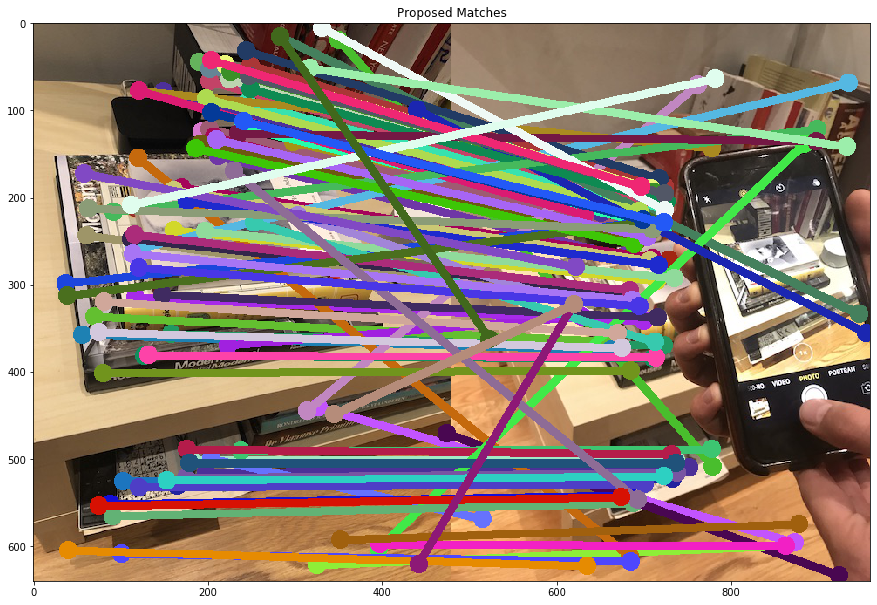

In [40]:
num_pts_to_visualize = 100
num_pts_total = min(pts1.shape[0], pts2.shape[0])
pts_to_viz = np.random.choice(np.arange(num_pts_total), num_pts_to_visualize, replace=False)

c2 = show_correspondence_lines(image1, image2,
                    pts1[pts_to_viz, 0], pts1[pts_to_viz, 1],
                    pts2[pts_to_viz, 0], pts2[pts_to_viz, 1],)
plt.figure(figsize=(15,20)) 
plt.title('Proposed Matches')
plt.imshow(c2)

In [41]:
from proj2_code.ransac import ransac_fundamental_matrix

F, matches_x0, matches_x1 = ransac_fundamental_matrix(pts1, pts2)
print('Fundamental matrix=', F)

Fundamental matrix= [[  -0.00115089   -0.00333204    1.01877922]
 [   0.00301621   -0.00068724   -0.77154477]
 [  -0.03935146    1.16729152 -230.27049019]]


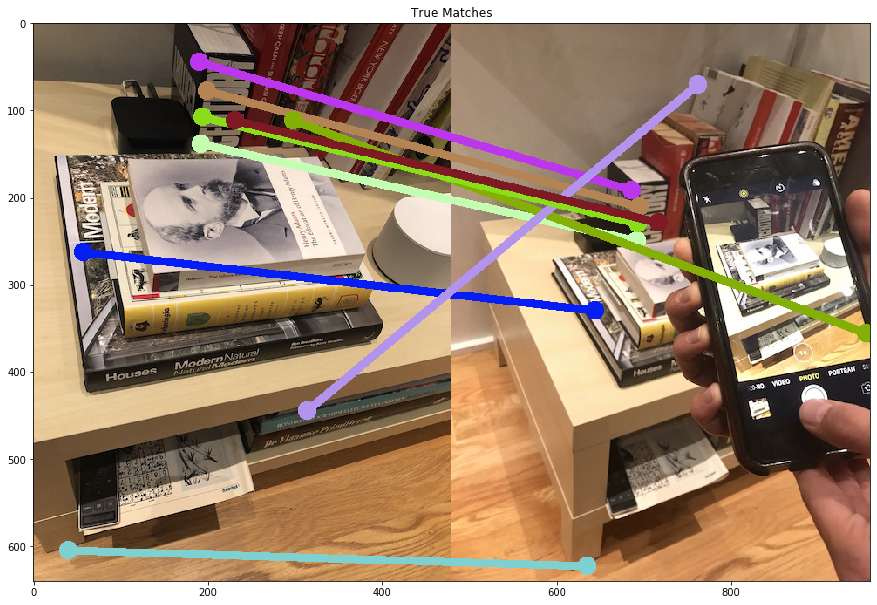

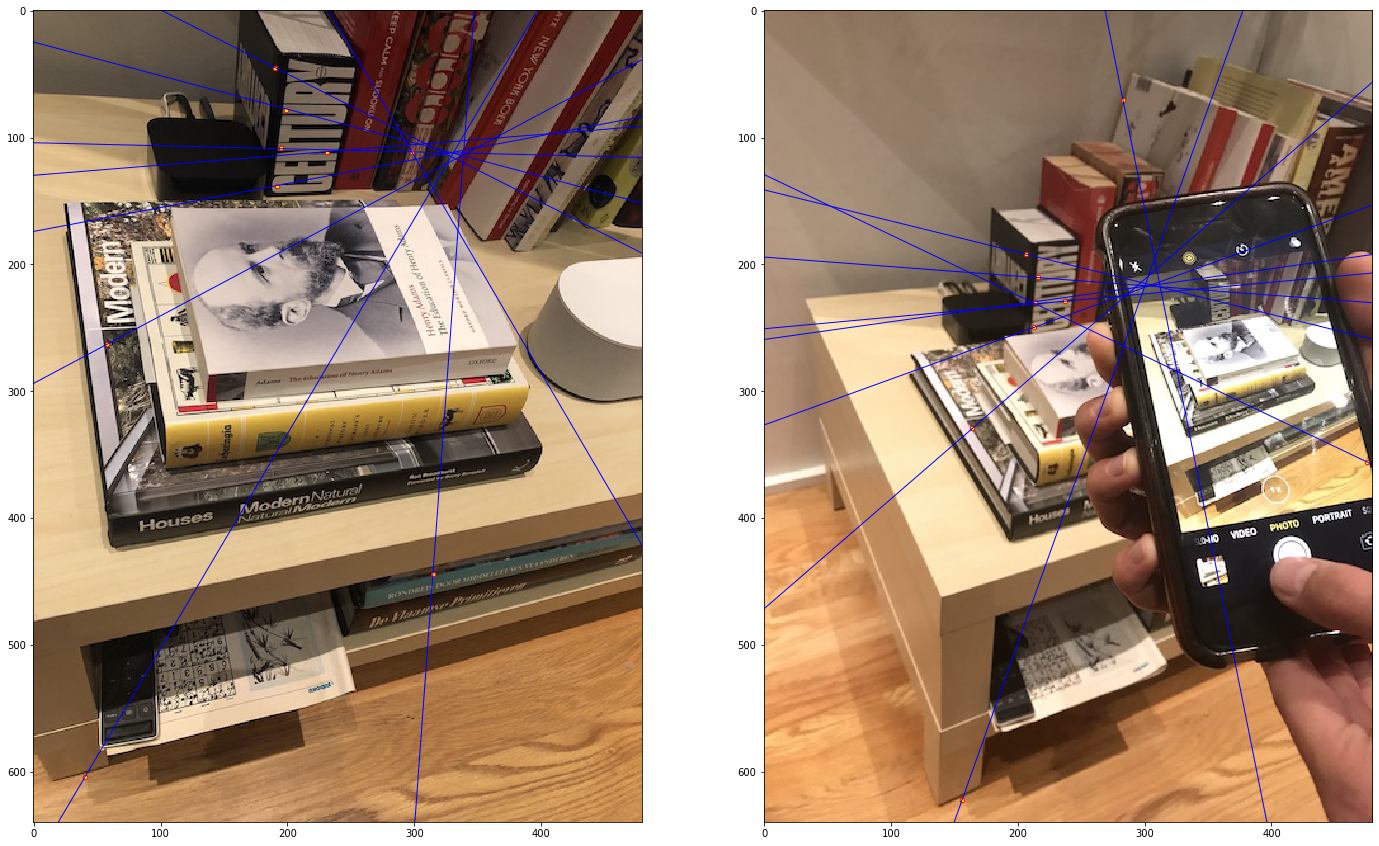

In [42]:
from proj2_code.utils import draw_epipolar_lines
# Draw the epipolar lines on the images and corresponding matches

num_pts_to_visualize = min(50, matches_x0.shape[0])
num_pts_total = matches_x0.shape[0]
pts_to_viz = np.random.choice(np.arange(num_pts_total), num_pts_to_visualize, replace=False)

match_image = show_correspondence_lines(image1, image2,
                                   matches_x0[pts_to_viz, 0], matches_x0[pts_to_viz, 1],
                                   matches_x1[pts_to_viz, 0], matches_x1[pts_to_viz, 1])
plt.figure(figsize=(15,20))
plt.title('True Matches')
plt.imshow(match_image)


draw_epipolar_lines(F, image1, image2, matches_x0, matches_x1)

# Part 4: Pose recovery from the fundamental matrix
Note: This part is compulsory for grad students. Undergraduate students can attempt this for up to 10 points worth of extra credits.

## Part 4.1 Recover essential matrix from fundamental matrix
Given the fundamental matrix, we can use the camera intrinsics to recover the essential matrix. Refer to the writeup/lecture slides for more details and the final equation.

For sake of simplicity, we will use the same calibration matrix for both the cameras. We will reuse the fundamental matrix computed in the previous part

In [43]:
# defining the camera intrinsic matrix
K = np.array([[600, 0, 240],
              [0, 600, 320],
              [0, 0, 1]
             ])

from proj2_code.recover_rot_translation import recover_E_from_F

E = recover_E_from_F(F, K)

print('Recovered essential matrix = ', E)

Recovered essential matrix =  [[ -414.31903907 -1199.53481993  -194.21198475]
 [ 1085.8359973   -247.40596015  -160.54231093]
 [  389.77404195    88.61113708   -29.48891406]]


In [44]:
from proj2_unit_tests.test_essential_matrix_decomposition import TestEssentialMatrixDecomposition

test_essential_matrix = TestEssentialMatrixDecomposition()
test_essential_matrix.setUp()
print("test_recover_E_from_F(): " + verify(test_essential_matrix.test_recover_E_from_F))

test_recover_E_from_F(): "Correct"


## Part 4.2 Recover relative rotation and translation between camera poses


In [45]:
from proj2_code.recover_rot_translation import recover_rot_translation_from_E

R1, R2, t = recover_rot_translation_from_E(E)

print('Rotation candidate #1 = ', R1)
print('Rotation candidate #2 = ', R2)
print('translation (scale and sign ambiguous) = ', t)

Rotation candidate #1 =  [0.00798589 3.06443317 0.01585207]
Rotation candidate #2 =  [ 3.01156396  0.16042818 -0.63227654]
translation (scale and sign ambiguous) =  [ 0.12912511 -0.29155362  0.94779913]


In [46]:
from proj2_unit_tests.test_essential_matrix_decomposition import TestEssentialMatrixDecomposition

test_essential_matrix = TestEssentialMatrixDecomposition()
test_essential_matrix.setUp()
print("test_recover_rot_translation_from_E(): " + verify(test_essential_matrix.test_recover_rot_translation_from_E))

test_recover_rot_translation_from_E(): "Correct"
